# Programmieraufgabe IV     ( 6 + 10 + 4 = 20 Punkte) 
## Abgabe in der Woche 17. bis 21. Dezember

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.linalg as la

## Teilaufgabe a) 

Schreiben Sie eine Funktion, die eine gegebene Matrix $A$ (numpy-array) mittels Householder-Transformationen in eine obere Hessenbergmatrix überführt. 


In [29]:
def householdertrafo(arg, w): 
    
    ## Diese Funktion soll eine Householder-Transformation $I - 2ww^T$ auf das Argument arg (Matrix oder Vektor) anwenden.
    
    l = len(w)
    
    ## Berechne I - 2ww^T
    H_ = np.identity(l)
    for i in range (l):
        for j in range (l):
            H_[i][j] -= 2*w[i]*w[j]
    
    (num_rows, num_cols) = np.shape(arg)
    
    ## Bringe die Matrix für die Householder-Transformation auf passende Größe indem H_ in die rechte untere #
    ## Ecke einer sonst Einheitsmatrix kommt
    H = np.identity(num_rows)
    H[num_rows-l:, num_rows-l:] = H_
    
    ## Führe Householder-Transformation auf arg aus
    result = H.T@arg@H
    
    return (result, H)


def intohessenberg(B):
    
    A = np.copy(B)
    (num_rows, num_cols) = np.shape(A)
    
    for i in range (num_rows-2):
        x = A[i+1:, i]
        e = np.zeros_like(x, dtype=float)
        e[0] = np.linalg.norm(x)*np.sign(x[0])
        v = x + e
        w = v / np.linalg.norm(v)
        (A, H) = householdertrafo(A, w)
        
        ## der folgende Schritt kann auch weggelassen werden, aber da wir wissen, dass diese Einträge nur durch 
        ## Rundungsfehler nicht 0 sind, setzen wir diese auf 0
        A[i+2:, i] = 0.
    
    return A

A = np.array([[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7]])
print("test: ", intohessenberg(A))

test:  [[  1.00000000e+00  -5.38516481e+00   1.09061106e-16  -2.07756313e-17]
 [ -5.38516481e+00   1.52068966e+01  -1.68930327e+00  -8.32667268e-16]
 [  0.00000000e+00  -1.68930327e+00  -2.06896552e-01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.10194533e-16  -1.63147961e-16]]


## Teilaufgabe b)

Implementieren Sie das in der Vorlesung behandelte QR-Verfahren zur Eigenwertbestimmung einer oberen Hessenbergmatrix $A$ (numpy-array). Input der Funktion soll die Matrix $A$, eine maximale Anzahl von Iterationen $itmax$ und eine Toleranz $tol$ sein, die in ein (sinnvolles) Abbruchkriterium eingeht.

Ausgegeben werden soll ein array mit den Näherungen für die Eigenwerte, geordnet nach Größe. Außerdem soll eine Liste der Eigenwertnäherungen aller Iterationen ausgegeben werden. 

Beachten Sie, dass hier die __in der Vorlesung besprochene praktische Umsetzung des QR-Verfahrens zur Eigenwertbestimmung__ implementiert werden soll, d.h. ein bloßes Ausrechnen der QR-Zerlegung $A=QR$ und anschließende Zuweisung $A \leftarrow RQ$, explizites Aufstellen und Ausmultiplizieren von Givens-Rotations-Matrizen etc. soll hier _nicht_ verwendet werden!

Testen Sie Ihre Implementierung, indem Sie Ihre Ergebnisse für für eine zufällige symmetrische $10x10$-Matrix und die übliche Matrix $A = \text{tridiag}(-1,4,1) \in \mathbb{R}^{5 \times 5}$ mit der in numpy vorimplementierten Eigenwertberechnung (wählen Sie eine geeignete Routine) vergleichen. 

In [79]:
## benötigte Givensrotation von links G(i,i+1)
def giv_left(B, c, s, i):
    A = np.copy(B)
    r0 = np.array(A[i, :])
    r1 = np.array(A[i+1, :])
    A[i, :] = c*r0 + s*r1
    A[i+1, :] = -s*r0 + c*r1
    return A

## benötigte Givensrotation von rechts G(i,i+1)^T
def giv_t_right(B, c, s, i):
    A = np.copy(B)
    c0 = np.array(A[:, i])
    c1 = np.array(A[:, i+1])
    A[:, i] = c*c0 + s*c1
    A[:, i+1] = -s*c0 + c*c1
    return A


def qr_eigenvalues(B, itmax, tol):
    
    (num_rows, num_cols) = np.shape(B)
    j = 0
    
    ## Transformieren zuerst A in HB Form
    A = intohessenberg(B)
    eigvalslist = np.array([])
    
    ## Führen pro Iteration einen Schritt des QR-Verfahrens für HB Matrizen aus (O(n^2))
    while j < itmax and np.linalg.norm(A) - np.linalg.norm(np.diag(A)) > tol:

        ## Wissen: R = G(n-1, n)*...*G(1, 2)*A und außerdem RQ = G(n-1, n)*...*G(1, 2)*A*G(1, 2).T*...*G(n-1, n).T
        ## müssen bei Berechnung von RQ jedoch aufpassen, dass wir die Rechtsmult erst machen wenn wir die Spalten
        ## von R die verändert werden schon errechnet haben -> Rechtsmult immer einen Schritt später
        w = A[:2,0]
        c_new = w[0]/np.linalg.norm(w)
        s_new = w[1]/np.linalg.norm(w)
        
        R = giv_left(A, c_new, s_new, 0)
        RQ = giv_left(A, c_new, s_new, 0)
        
        for i in range (1, num_rows-1):
            c_old = c_new
            s_old = s_new
            
            w = R[i:i+2,i]
            c_new = w[0]/np.linalg.norm(w)
            s_new = w[1]/np.linalg.norm(w)
            
            R = giv_left(R, c_new, s_new, i)
            
            ## wie oben erklärt, Rechtsmult bei RQ erst eins später
            RQ = giv_left(RQ, c_new, s_new, i)
            RQ = giv_t_right(RQ, c_old, s_old, i-1)
            
            
        RQ = giv_t_right(RQ, c_new, s_new, num_rows-2)
        A = RQ
        eigvalslist = np.append(eigvalslist, np.diag(A))
        j += 1
    
    eigvals = np.diag(A)
    
    return (eigvals, eigvalslist)

C = np.array([[3.,1.],[4.,2.]])
print("C:\n", C)
print("C in HB trafo:\n", intohessenberg(C))
print("\nEigenwerte Python: ", np.linalg.eigvals(C))
(eigvals, eigvalslist) = qr_eigenvalues(C, 100, 0)
print("Eigenwerte Selbst: ", eigvals)

B = np.array([[4,-1,0,0,0],[-1,4,-1,0,0],[0,-1,4,-1,0],[0,0,-1,4,-1],[0,0,0,-1,4]])
print("\n\nVorgegebenes B:\n", B)
print("B in HB trafo:\n", intohessenberg(B))
print("\nEigenwerte Python: ", np.linalg.eigvals(B))
(eigvals, eigvalslist) = qr_eigenvalues(B, 100, 0)
print("Eigenwerte Selbst: ", eigvals)

M = np.random.rand(10,10)
M = M.T@M
print("\n\nZufälliges M:\n", M)
print("M in HB trafo:\n", intohessenberg(M))
print("\nEigenwerte Python: ", np.linalg.eigvals(M))
(eigvals, eigvalslist) = qr_eigenvalues(M, 100, 0)
print("Eigenwerte Selbst: ", eigvals)

C:
 [[ 3.  1.]
 [ 4.  2.]]
C in HB trafo:
 [[ 3.  1.]
 [ 4.  2.]]

Eigenwerte Python:  [ 4.56155281  0.43844719]
Eigenwerte Selbst:  [ 4.56155281  0.43844719]


Vorgegebenes B:
 [[ 4 -1  0  0  0]
 [-1  4 -1  0  0]
 [ 0 -1  4 -1  0]
 [ 0  0 -1  4 -1]
 [ 0  0  0 -1  4]]
B in HB trafo:
 [[ 4.  1.  0.  0.  0.]
 [ 1.  4. -1.  0.  0.]
 [ 0. -1.  4. -1.  0.]
 [ 0.  0. -1.  4.  1.]
 [ 0.  0.  0.  1.  4.]]

Eigenwerte Python:  [ 2.26794919  3.          4.          5.73205081  5.        ]
Eigenwerte Selbst:  [ 5.73205081  5.          4.          3.          2.26794919]


Zufälliges M:
 [[ 4.82203469  2.92534661  3.59976717  4.05138199  1.78767104  2.85775196
   3.49652135  3.82581691  3.68822065  3.74851007]
 [ 2.92534661  3.02843665  2.2088036   2.81124938  1.05431131  2.74206636
   2.38770751  2.00588857  2.11990258  2.40325403]
 [ 3.59976717  2.2088036   2.91688154  3.13129919  1.42955894  2.11312081
   2.77131979  3.02542845  2.5642016   3.12875514]
 [ 4.05138199  2.81124938  3.13129919  4.0

## Teilaufgabe c) 

Erstellen Sie einen Plot, aus dem für jeden Eigenwert der Matrix die Konvergenzgeschwindigkeit der jeweiligen Eigenwertnäherungen des QR-Verfahrens hervorgeht. Als die "richtigen" Eigenwerte können Sie beispielsweise die mit einer numpy-Routine berechneten Eigenwerte oder die letzte Iterierte Ihres Verfahrens verwenden. 

Test-Matrix soll $B = B(a,b,c,d)$ wie unten angegeben sein. 

Variieren Sie die Parameter $a,b,c,d$ und interpretieren Sie Ihre Beobachtungen.

Errechnete Eigenwerte:  [ 4.  3.  2.  1.]


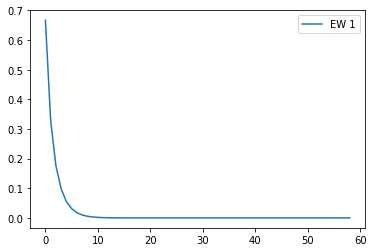

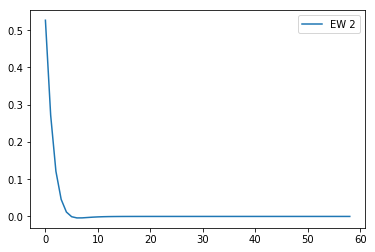

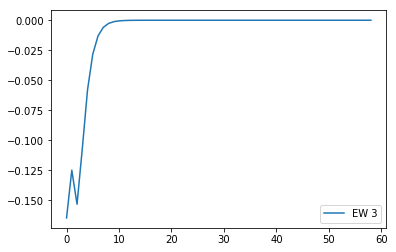

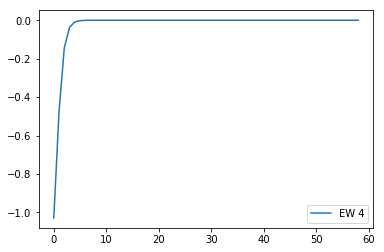

In [75]:
a = 1
b = 2 
c = 3
d = 4

T = 0.5*np.array([[1,1,1,1],[1,1,-1,-1],[-1,1,-1,1],[-1,1,1,-1]])
B = np.diag([a,b,c,d])
B = np.matmul(T.T, np.matmul(B,T))

(eigvals, eigvalslist) = qr_eigenvalues(B, 100, 0)
eigvalslist = np.reshape(eigvalslist, (int(eigvalslist.size/4), 4))

print("Errechnete Eigenwerte: ", eigvals)

plt.plot(eigvals[0] - eigvalslist[:, 0], label = 'EW 1')
plt.legend()
plt.show()
plt.close()

plt.plot(eigvals[1] - eigvalslist[:, 1], label = 'EW 2')
plt.legend()
plt.show()
plt.close()

plt.plot(eigvals[2] - eigvalslist[:, 2], label = 'EW 3')
plt.legend()
plt.show()
plt.close()

plt.plot(eigvals[3] - eigvalslist[:, 3], label = 'EW 4')
plt.legend()
plt.show()
plt.close()